In [1]:
import os

import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from tqdm import tqdm
import statannot as sa
from scipy import stats

from lib.data import raw_io as io
from lib.data import processed_io as pio
from lib.data import conditions as cond
from lib.features import decomposition as de

In [2]:
np.random.seed(42)

In [3]:
DATA_PATH = os.path.join('..', 'data', 'processed', 'trials_by_celltype')

Load raw fluorescence data

In [4]:
raw_data = pio.load_sessions_by_day(DATA_PATH, max(cond.DAYS), catch_behaviour='include')
raw_data[cond.CellType.pyr][0].fluo.is_z_score

True

In [5]:
num_trial_frames = 390
trial_structure = de.TrialBasisFunctions(
    num_trial_frames, tone_duration=1.0, delay_duration=1.5, reward_duration=2.5
)

In [24]:
true_mean_fluorescence = {
    'cell_type': [],
    'cell_id': [],
    'mouse_id': [],
    'reward_delivered': [],  # False iff catch trial
    'trial_component': [],
    'mean_fluorescence': [],
}

for cell_type in raw_data:
    for mouse in raw_data[cell_type]:
        for reward_delivered in [True, False]:
        
            fluo = mouse.fluo.fluo[
                mouse.trial_timetable['reward_delivered'] == reward_delivered, :, :
            ].mean(axis=0)[:, :num_trial_frames]

            for trial_component in ['tone', 'delay', 'reward']:
                true_mean_fluorescence['cell_type'].extend([cell_type for i in range(mouse.fluo.num_cells)])
                true_mean_fluorescence['cell_id'].extend(mouse.fluo.cell_num)
                true_mean_fluorescence['mouse_id'].extend([mouse.mouse_id for i in range(mouse.fluo.num_cells)])
                true_mean_fluorescence['reward_delivered'].extend(
                    [reward_delivered for i in range(mouse.fluo.num_cells)]
                )
                true_mean_fluorescence['trial_component'].extend(
                    [trial_component for i in range(mouse.fluo.num_cells)]
                )
                true_mean_fluorescence['mean_fluorescence'].extend(
                    fluo[
                        :, getattr(trial_structure, trial_component)
                    ].mean(axis=1).tolist()
                )
            
del cell_type, mouse, fluo, trial_component, reward_delivered

In [25]:
for key, val in true_mean_fluorescence.items():
    print(f'{key}: {len(val)}')

cell_type: 20058
cell_id: 20058
mouse_id: 20058
reward_delivered: 20058
trial_component: 20058
mean_fluorescence: 20058


In [27]:
true_mean_fluorescence = pd.DataFrame(true_mean_fluorescence)
true_mean_fluorescence

,cell_type,cell_id,mouse_id,reward_delivered,trial_component,mean_fluorescence
0,pyr,0,CL174,True,tone,0.038677
1,pyr,1,CL174,True,tone,-0.011645
2,pyr,2,CL174,True,tone,-0.069487
3,pyr,3,CL174,True,tone,0.101969
4,pyr,4,CL174,True,tone,-0.047152
...,...,...,...,...,...,...
20053,vip,89,CL188,False,reward,-0.054073
20054,vip,90,CL188,False,reward,-0.099549
20055,vip,91,CL188,False,reward,0.120948
20056,vip,92,CL188,False,reward,-0.142022


In [17]:
dir(non_catch[cond.CellType.pyr][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_from_h5pygroup',
 '_save_to_h5pygroup',
 'cell_type',
 'day',
 'fluo',
 'from_spec',
 'load',
 'mouse_id',
 'save',
 'trial_timetable']

In [4]:
raw_data_by_day = {
    day: pio.load_sessions_by_day(DATA_PATH, day, catch_behaviour='exclude') for day in cond.DAYS
}

In [5]:
def get_mean_fluorescence_by_cell_type(daily_data: io.SessionTrials):
    mean_fluorescence = {}
    for cell_type in daily_data.keys():

        # Concatenate fluorescence of each mouse
        mean_fluorescence[cell_type] = daily_data[cell_type][0].fluo.trial_mean()
        
        # Transfer meta attributes from SessionTrials to LongFluorescence
        mean_fluorescence[cell_type].set_meta_attr('mouse_id', daily_data[cell_type][0].mouse_id)
        mean_fluorescence[cell_type].set_meta_attr('day', daily_data[cell_type][0].day)
        mean_fluorescence[cell_type].set_meta_attr('cell_type', daily_data[cell_type][0].cell_type)
            
        for i in range(1, len(daily_data[cell_type])):
            trial_mean_fluo = daily_data[cell_type][i].fluo.trial_mean()
            
            # Transfer meta attributes from SessionTrials to LongFluorescence
            trial_mean_fluo.set_meta_attr('mouse_id', daily_data[cell_type][i].mouse_id)
            trial_mean_fluo.set_meta_attr('day', daily_data[cell_type][i].day)
            trial_mean_fluo.set_meta_attr('cell_type', daily_data[cell_type][i].cell_type)
            
            mean_fluorescence[cell_type].append(
                trial_mean_fluo
            )
            del trial_mean_fluo

        print('Got {} {} cells'.format(mean_fluorescence[cell_type].fluo.shape[0], cell_type))
        mean_fluorescence[cell_type].remove_nan()
    
    return mean_fluorescence

In [6]:
mean_fluorescence_by_day = {
    day: get_mean_fluorescence_by_cell_type(raw_data_by_day[day]) 
    for day in raw_data_by_day.keys()
}

Got 1209 pyr cells
Got 189 som cells
Got 252 pv cells
Got 407 vip cells
Got 1462 pyr cells
Got 207 som cells
Got 285 pv cells
Got 487 vip cells
Got 1730 pyr cells
Got 236 som cells
Got 305 pv cells
Got 513 vip cells


/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 2 all-nan rows
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:765: ShapeWarning: `num_frames` in self (420) and other (435) do not match, 15 excess frames will be trimmed from the end of other
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 4 all-nan rows
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:765: ShapeWarning: `num_frames` in self (428) and other (420) do not match, 8 excess frames will be trimmed from the end of self
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 6 all-nan rows
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 3 all-nan 

Got 1848 pyr cells
Got 250 som cells
Got 340 pv cells
Got 534 vip cells
Got 1919 pyr cells
Got 276 som cells
Got 350 pv cells
Got 534 vip cells
Got 2026 pyr cells
Got 284 som cells
Got 354 pv cells
Got 562 vip cells
Got 2098 pyr cells
Got 318 som cells
Got 362 pv cells
Got 565 vip cells


/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 7 all-nan rows
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:765: ShapeWarning: `num_frames` in self (420) and other (438) do not match, 18 excess frames will be trimmed from the end of other
  warnings.warn(


In [7]:
def aggregate_fluorescence(daily_data, num_frames_to_keep=390):
    meta = []
    fluo_matrices = []
    for cell_type in cond.CellType:
        meta.append(daily_data[cell_type]._meta)
        fluo_matrices.append(daily_data[cell_type].fluo)

    min_num_frames = np.min([fl.shape[1] for fl in fluo_matrices])
    assert min_num_frames >= num_frames_to_keep

    meta = pd.concat(meta, ignore_index=True)
    meta.reset_index(inplace=True)
    
    grand_fluo = io.LongFluorescence(
        0, 
        meta['cell_num'], 
        np.concatenate([fl[:, :num_frames_to_keep] for fl in fluo_matrices])
    )
    
    meta['cell_uid'] = meta['mouse_id'] + '_' + meta['cell_type'].astype(str) + '_' + meta['cell_num'].astype(str)
    grand_fluo._meta = meta

    return grand_fluo

In [8]:
grand_fluo_by_day = {day: aggregate_fluorescence(mean_fluorescence_by_day[day]) for day in cond.DAYS}

In [9]:
grand_fluo = grand_fluo_by_day[cond.DAYS[0]]

for day in cond.DAYS[1:]:
    grand_fluo.append(grand_fluo_by_day[day])

grand_fluo.set_meta_attr('catch', False)

## Append catch trial data

In [10]:
raw_data_by_day = {
    day: pio.load_sessions_by_day(DATA_PATH, day, catch_behaviour='select') for day in cond.DAYS
}
mean_fluorescence_by_day = {
    day: get_mean_fluorescence_by_cell_type(raw_data_by_day[day]) 
    for day in raw_data_by_day.keys()
}
grand_fluo_by_day = {day: aggregate_fluorescence(mean_fluorescence_by_day[day]) for day in cond.DAYS}

for day in cond.DAYS:
    fl = grand_fluo_by_day[day]
    fl.set_meta_attr('catch', True)
    
    grand_fluo.append(fl)

Got 1209 pyr cells
Got 189 som cells
Got 252 pv cells
Got 407 vip cells
Got 1462 pyr cells
Got 207 som cells
Got 285 pv cells
Got 487 vip cells
Got 1730 pyr cells
Got 236 som cells
Got 305 pv cells
Got 513 vip cells
Got 1848 pyr cells
Got 250 som cells


/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:641: RuntimeWarning: Mean of empty slice.
  mean_fluo = LongFluorescence(0, self.cell_num, self.fluo.mean(axis=0))
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 120 all-nan rows
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 190 all-nan rows
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 189 all-nan rows
  warnings.warn(


Got 340 pv cells
Got 534 vip cells
Got 1919 pyr cells
Got 276 som cells
Got 350 pv cells
Got 534 vip cells
Got 2026 pyr cells
Got 284 som cells
Got 354 pv cells
Got 562 vip cells


/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 191 all-nan rows
  warnings.warn(


Got 2098 pyr cells
Got 318 som cells
Got 362 pv cells
Got 565 vip cells


In [11]:
first_day = []
known_first_days = {}

for uid in tqdm(grand_fluo.get_meta_attr('cell_uid')):
    maybe_first_day = known_first_days.get(uid, False)
    if not maybe_first_day:
        first_day_this_uid = min(
            grand_fluo.get_meta_attr('day')[
                grand_fluo.get_meta_attr('cell_uid') == uid
            ]
        )
        known_first_days[uid] = first_day_this_uid
        first_day.append(first_day_this_uid)
    else:
        first_day.append(maybe_first_day)

grand_fluo.set_meta_attr('first_day', first_day)

del first_day, known_first_days

100%|██████████| 38763/38763 [00:10<00:00, 3839.80it/s]


In [12]:
grand_fluo.get_meta_attr('catch')

0        False
1        False
2        False
3        False
4        False
         ...  
38758     True
38759     True
38760     True
38761     True
38762     True
Name: catch, Length: 38763, dtype: bool

In [13]:
grand_fluo.fluo.shape

(38763, 390)

In [14]:
trial_structure = de.TrialBasisFunctions(390, tone_duration=1.0, delay_duration=1.5, reward_duration=2.5)

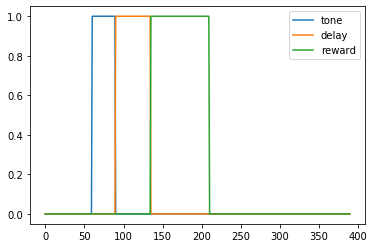

In [15]:
plt.plot(trial_structure.tone, label='tone')
plt.plot(trial_structure.delay, label='delay')
plt.plot(trial_structure.reward, label='reward')
plt.legend()
plt.show()

In [17]:
(grand_fluo.get_meta_attr('catch') == True) & (grand_fluo.get_meta_attr('day') == max(cond.DAYS))

0        False
1        False
2        False
3        False
4        False
         ...  
38758     True
38759     True
38760     True
38761     True
38762     True
Length: 38763, dtype: bool

In [18]:
grand_fluo.fluo.shape

(38763, 390)

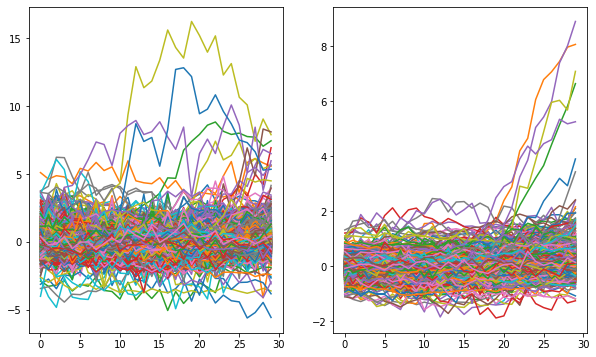

In [20]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.plot(
    grand_fluo.fluo[
        (grand_fluo.get_meta_attr('catch') == True) 
        & (grand_fluo.get_meta_attr('day') == max(cond.DAYS)),
        :
    ][
        :, trial_structure.tone
    ].T
)

plt.subplot(122)
plt.plot(
    grand_fluo.fluo[
        (grand_fluo.get_meta_attr('catch') == False) 
        & (grand_fluo.get_meta_attr('day') == max(cond.DAYS)),
        :
    ][
        :, trial_structure.tone
    ].T
)

plt.show()

In [21]:
stats.mannwhitneyu(
    grand_fluo.fluo[
        (grand_fluo.get_meta_attr('catch') == True) 
        & (grand_fluo.get_meta_attr('day') == max(cond.DAYS)),
        :
    ][
        :, trial_structure.tone
    ].mean(axis=1),
    grand_fluo.fluo[
        (grand_fluo.get_meta_attr('catch') == False) 
        & (grand_fluo.get_meta_attr('day') == max(cond.DAYS)),
        :
    ][
        :, trial_structure.tone
    ].mean(axis=1)
)

MannwhitneyuResult(statistic=4869563.0, pvalue=1.066171777854693e-17)

(-2, 2)

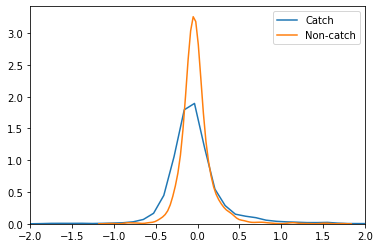

In [23]:
sns.kdeplot(
    grand_fluo.fluo[
        (grand_fluo.get_meta_attr('catch') == True) 
        & (grand_fluo.get_meta_attr('day') == max(cond.DAYS)),
        :
    ][
        :, trial_structure.tone
    ].mean(axis=1),
    label='Catch'
)
sns.kdeplot(
    grand_fluo.fluo[
        (grand_fluo.get_meta_attr('catch') == False) 
        & (grand_fluo.get_meta_attr('day') == max(cond.DAYS)),
        :
    ][
        :, trial_structure.tone
    ].mean(axis=1),
    label='Non-catch'
)
plt.legend()
plt.xlim(-2, 2)

In [24]:
mean_fluo_during_tone = grand_fluo.fluo[:, trial_structure.tone].mean(axis=1)
statdf = pd.DataFrame({'tone': mean_fluo_during_tone, 'catch': grand_fluo.get_meta_attr('catch'), 'day': grand_fluo.get_meta_attr('day'), 'uid': grand_fluo.get_meta_attr('cell_uid')})
statday1 = statdf.loc[statdf['day'] == cond.Day(1), :].pivot(index='uid', columns='catch', values='tone')

statday1

catch,False,True
uid,,
CL136_vip_0,0.006833,NaN
CL136_vip_1,0.078297,NaN
CL136_vip_10,0.059184,NaN
CL136_vip_100,-0.032092,NaN
CL136_vip_101,0.027145,NaN
...,...,...
CL196_pv_63,-0.091753,-0.365007
CL196_pv_64,0.011182,-0.223480
CL196_pv_7,0.148927,-0.525128


In [25]:
stats.wilcoxon(statday1.iloc[:, 0], statday1.iloc[:, 1])

/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


WilcoxonResult(statistic=716799.0, pvalue=7.226321797874514e-36)

In [28]:
no_catch_mask = np.isnan(statday1.iloc[:, 1])
stats.wilcoxon(statday1.iloc[:, 0][~no_catch_mask], statday1.iloc[:, 1][~no_catch_mask])

WilcoxonResult(statistic=716799.0, pvalue=1.257588031473388e-18)

# Uh oh

Why is the calcium response during the tone significantly different during catch trials?

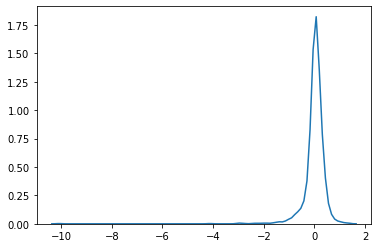

In [29]:
sns.kdeplot(statday1.iloc[:, 0] - statday1.iloc[:, 1])

In [30]:
(statday1.iloc[:, 0] - statday1.iloc[:, 1]).median()

0.0484958

# Why my first analysis was wrong

Initially, I averaged the fluorescence signal 1) over time within each trial and 2) over trials of the same type (catch or non-catch) within each cell. This gave me two data points per cell corresponding to the average fluorescence during catch and non-catch trials, which I then used for statistics.

This gives very wrong p-values because there were very few catch trials.

To see why, take a look at what happens when I average over some random fluorescence data using an unbalanced number of trials.

Simulating mean fluorescence of 3000 cells over 35 trials


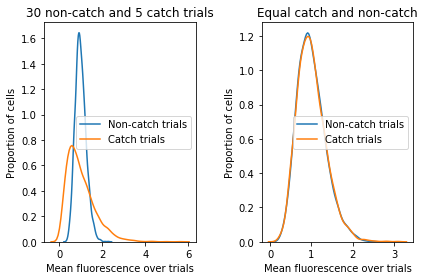

In [118]:
num_cells = 3000

num_non_catch = 30
num_catch = 5
num_trials = num_non_catch + num_catch

print(f'Simulating mean fluorescence of {num_cells} cells over {num_trials} trials')
# Simulate some fluorescence data
simulated_mean_fluorescence = np.random.normal(
    size=(num_trials, num_cells)
)**2

def average_over_trials(x):
    return x.mean(axis=0)

# Distribution of mean fluorescence over all cells according to trial type

# Few catch trials
plt.subplot(121)
plt.title(f'{num_non_catch} non-catch and {num_catch} catch trials')
sns.kdeplot(
    average_over_trials(simulated_mean_fluorescence[:num_non_catch, :]), 
    label='Non-catch trials'
)
sns.kdeplot(
    average_over_trials(simulated_mean_fluorescence[-num_catch:, :]), 
    label='Catch trials'
)
plt.ylabel('Proportion of cells')
plt.xlabel('Mean fluorescence over trials')

# Equal catch and non-catch trials
plt.subplot(122)
plt.title(f'Equal catch and non-catch')
sns.kdeplot(
    average_over_trials(simulated_mean_fluorescence[:num_trials // 2, :]), 
    label='Non-catch trials'
)
sns.kdeplot(
    average_over_trials(simulated_mean_fluorescence[-(num_trials // 2):, :]), 
    label='Catch trials'
)
plt.ylabel('Proportion of cells')
plt.xlabel('Mean fluorescence over trials')

plt.tight_layout()
plt.show()

This has a pretty profound effect on p-values (see below).

In [114]:
from textwrap import fill

num_p_values_under_005 = {
    'few_catch_trials': 0,
    'equal_catch_trials': 0
}
num_rounds = 5000
for i in tqdm(range(num_rounds)):
    simulated_mean_fluorescence = np.random.normal(
        size=(num_trials, num_cells)
    )**2
    
    # Compute significance using only a few catch trials
    w_statistic, p_value = stats.wilcoxon(
        average_over_trials(simulated_mean_fluorescence[:num_non_catch, :]), 
        average_over_trials(simulated_mean_fluorescence[-num_catch:, :]),
    )
    if p_value < 0.05:
        num_p_values_under_005['few_catch_trials'] += 1
        
    # Compute significance using equal number of catch and non-catch trials
    w_statistic, p_value = stats.wilcoxon(
        average_over_trials(simulated_mean_fluorescence[:(num_trials // 2), :]), 
        average_over_trials(simulated_mean_fluorescence[(num_trials // 2):, :]),
    )
    if p_value < 0.05:
        num_p_values_under_005['equal_catch_trials'] += 1
        
print(
    fill(f'p < 0.05 {100 * num_p_values_under_005["few_catch_trials"] / num_rounds} pct of the time '
    f'using {num_catch} catch and {num_non_catch} non-catch trials, but only '
    f'{100 * num_p_values_under_005["equal_catch_trials"] / num_rounds} pct of the time using '
    'equal numbers of catch and non-catch trials.')
)

100%|██████████| 5000/5000 [00:19<00:00, 253.91it/s]

p < 0.05 99.34 pct of the timeusing 5 catch and 30 non-catch trials,
but only 5.14 pct of the time using equal numbers of catch and non-
catch trials.


Using the same randomly-generated data, the p-values obtained **based on trial averages** are very different depending on whether the numbers of catch and non-catch trials are equal. (Normally, $p < 0.05$ should only happen 5 pct of the time by random chance.)

# Shuffle test

In [121]:
mean_fluo_during_tone = grand_fluo.fluo[:, trial_structure.tone].mean(axis=1)
statdf = pd.DataFrame(
    {
        'tone': mean_fluo_during_tone, 
        'catch': grand_fluo.get_meta_attr('catch'), 
        'day': grand_fluo.get_meta_attr('day'), 
        'uid': grand_fluo.get_meta_attr('cell_uid')
    }
)
stat_day = statdf.loc[statdf['day'] == cond.Day(7), :]

stat_piv = stat_day.pivot(index='uid', columns='catch', values='tone')
catch_effect = stat_piv.iloc[:, 1] - stat_piv.iloc[:, 0]

num_rounds = 5000
shuffle_catch_effects = np.empty((len(catch_effect), num_rounds))
for i in tqdm(range(num_rounds)):
    
    stat_day['catch'] = np.random.permutation(stat_day['catch'])
    stat_piv = stat_day.pivot(index='uid', columns='catch', values='tone')
    suffle_catch_effects[:, i] = stat_piv.iloc[:, 1] - stat_piv.iloc[:, 0]

  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-121-bd2115b28d6a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_day['catch'] = np.random.permutation(stat_day['catch'])
  0%|          | 0/5000 [00:00<?, ?it/s]


ValueError: Index contains duplicate entries, cannot reshape